# Experimentation

## Parser for OData Queries

In [141]:
# Test cases
test_cases = [
    "ColA eq 3",
    "ColB eq 'abc'",
    "ColA eq 3 and ColB eq 'abc'",
    "startswith(ColA, 'hello')",
    "(ColA eq 3 and ColB eq 'abc') or (ColC eq 55 and ColD = 'lel')",
    "startswith(ColA, 'hello') and substringof('hello', ColB)",
]

In [145]:
import re

def parse_odata_filter(query):
    # lt
    query = query.replace(' lt ', ' < ')
    # le
    query = query.replace(' le ', ' <= ')
    # gt
    query = query.replace(' gt ', ' > ')
    # ge
    query = query.replace(' ge ', ' >= ')
    # eq
    query = query.replace(' eq ', ' = ')
    # ne
    query = query.replace(' ne ', ' != ')
    # startswith(column, string)
    matches_sw = re.match('startswith\(.*?\)', query.lower())
    if matches_sw:
        span_sw = matches_sw.span()
        sw_query = query[span_sw[0]:span_sw[1]]
        # Extract text between brackets
        sw_terms = re.sub('.*\(', '', sw_query)
        sw_terms = re.sub('\).*', '', sw_terms)
        sw_terms = [s.strip() for s in sw_terms.split(',')]
        sw_terms[1] = re.sub('[^a-zA-Z0-9]', '', sw_terms[1])
        query = re.sub(sw_query.replace('(', '\(').replace(')', '\)'), f"{sw_terms[0]} LIKE '{sw_terms[1]}%'", query)
        
    # substringof(string, column)
    matches_so = re.search('substringof\(.*?\)', query.lower())
    if matches_so:
        span_so = matches_so.span()
        so_query = query[span_so[0]:span_so[1]]
        # Extract text between brackets
        so_terms = re.sub('.*\(', '', so_query)
        so_terms = re.sub('\).*', '', so_terms)
        so_terms = [s.strip() for s in so_terms.split(',')]
        so_terms[0] = re.sub('[^a-zA-Z0-9]', '', so_terms[0])
        query = re.sub(so_query.replace('(', '\(').replace(')', '\)'), f"{so_terms[1]} LIKE '%{so_terms[0]}%'", query)
    # day()
    # month()
    # year()
    # hour()
    # minute()
    # second()
    return query

In [146]:
parse_odata_filter(test_cases[-1])

"ColA LIKE 'hello%' and ColB LIKE '%hello%'"

In [147]:
for test_case in test_cases:
    print(parse_odata_filter(test_case))

ColA = 3
ColB = 'abc'
ColA = 3 and ColB = 'abc'
ColA LIKE 'hello%'
(ColA = 3 and ColB = 'abc') or (ColC = 55 and ColD = 'lel')
ColA LIKE 'hello%' and ColB LIKE '%hello%'


In [16]:
def parse_odata_filter(query, joins):
  # Replace lookup column with the associated table
  main_col_matches = re.findall('\w+\/', query)
  main_col_replacements = []
  for match in main_col_matches:
    main_col_replacements.append(joins[match[:-1]]['table'])
  for match, replacement in zip(main_col_matches, main_col_replacements):
    query = re.sub(match, replacement + '.', query)
  
  # Replace slashes with dots
  # query = query.replace('/', '.')
  # lt
  query = query.replace(' lt ', ' < ')
  # le
  query = query.replace(' le ', ' <= ')
  # gt
  query = query.replace(' gt ', ' > ')
  # ge
  query = query.replace(' ge ', ' >= ')
  # eq
  query = query.replace(' eq ', ' = ')
  # ne
  query = query.replace(' ne ', ' != ')
  # startswith(column, string)
  query = re.sub('startsWith', 'startswith', query, re.IGNORECASE)
  matches_sw = re.findall('startswith\(.*?\)', query)
  if len(matches_sw) > 0:
    for match in matches_sw:
      # Extract text between brackets
      sw_terms = re.sub('.*\(', '', match)
      sw_terms = re.sub('\).*', '', sw_terms)
      sw_terms = [s.strip() for s in sw_terms.split(',')]
      sw_terms[1] = re.sub('[^a-zA-Z0-9]', '', sw_terms[1])
      query = re.sub(match.replace('(', '\(').replace(')', '\)'), f"{sw_terms[0]} LIKE '{sw_terms[1]}%'", query)
      
      print(query)
      
  # substringof(string, column)
  matches_so = re.findall('substringof\(.*?\)', query, re.IGNORECASE)
  if len(matches_so) > 0:
    for match in matches_so:
      # Extract text between brackets
      so_terms = re.sub('.*\(', '', match)
      so_terms = re.sub('\).*', '', so_terms)
      so_terms = [s.strip() for s in so_terms.split(',')]
      so_terms[0] = re.sub('[^a-zA-Z0-9]', '', so_terms[0])
      query = re.sub(match.replace('(', '\(').replace(')', '\)'), f"{so_terms[1]} LIKE '%{so_terms[0]}%'", query)
  
  # day()

  # month()
  
  # year()
  
  # hour()
  
  # minute()
  
  # second()
  
  return query

In [20]:
query1 = {
    '$select': 'Id,tableTitle,parentDatasetID/datasetTitle,parentDatasetID/dataDomain,parentDatasetID/owner',
    '$filter': "startswith(parentDatasetID/dataDomain,'O') and startswith(parentDatasetID/owner,'B')",
    '$expand': 'parentDatasetID'
}

query2 = {
    '$select': 'Id,tableTitle,parentDatasetID/datasetTitle,parentDatasetID/dataDomain,parentDatasetID/owner',
    '$filter': "parentDatasetID/dataDomain eq 'Ops'",
    '$expand': 'parentDatasetID'
}

joins = {
    'parentDatasetID': {
        'table': 'dc_datasets'
    }
}

In [31]:
import re

def parse_odata_query(query):
    output = {
        'main_cols': [],
        'join_cols': [],
        'filter_query': '',
        'expand_cols': []
    }
    if not query:
        return
    for query, value in query.items():
        if query == '$filter':
            output['filter_query'] = value
        else:
            columns = [v.strip() for v in value.split(',')]
            if query == '$select':    
                for column in columns:
                    if '/' in column:
                        output['join_cols'].append(column)
                    else:
                        output['main_cols'].append(column)
            elif query == '$expand':
                output['expand_cols'].extend(columns)
    return output

In [32]:
parse_odata_query(query1)

{'main_cols': ['Id', 'tableTitle'],
 'join_cols': ['parentDatasetID/datasetTitle',
  'parentDatasetID/dataDomain',
  'parentDatasetID/owner'],
 'filter_query': "startswith(parentDatasetID/dataDomain,'O') and startswith(parentDatasetID/owner,'B')",
 'expand_cols': ['parentDatasetID']}

## Generate Fake Data
The fake data generator creates fake domains, datasets, and the full underlying tables.

- Domains: Arbitrary groups of datasets
- Datasets

The underlying tables include lookup tables, transactional tables, and metadata for all of them.

### 1. Lookup Tables
People: 1,000 people generated using `.profile()`:
- name
- sex
- address
- mail (email)
- birthdate
- company
- job

Job:
- Job: Choose 50 from people/job and randomise for all
- Job description: generate_key_thrust

Company:
- Choose 50 from people/company and randomise for all
- Company description: generate_key_thrust

### 2. Transactional Tables
Training:
- Date: date


### 3. Metadata
Domains: Ops, Manpower, Intel, Engineering, Training, Safety

Datasets:
- Title: Define list
- Use case: Key thrusts
- Owner: company
- Point of contact: first_name, last_name, company_email

Tables:
- Title: Define list, dependent on dataset
- Table description: Key thrusts
- Update frequency: daily, weekly, monthly, quarterly
- Site: url
- spId: md5 hash of title + description

Columns:
- Depends on menu

In [6]:
import numpy as np
import pandas as pd

from faker import Faker

In [7]:
fake = Faker()
Faker.seed(0)

In [31]:
def generate_key_thrust():
  verbs = ['exploit', 'enhance', 'establish', 'develop', 'grow', 'construct']
  return f"{fake.bs().capitalize()} to {np.random.choice(verbs)} {fake.catch_phrase().lower()}"

### Generate People Dataset

In [12]:
def get_person():
  fake_profile = fake.profile()
  output = {
    'name': fake_profile['name'],
    'sex': fake_profile['sex'],
    'address': fake_profile['address'],
    'mail': fake_profile['mail'],
    'birthdate': fake_profile['birthdate'],
    'company': fake_profile['company'],
    'job': fake_profile['job']
  }
  return output

In [61]:
people_df = []
for _ in range(1000):
  people_df.append(get_person())

people_df = pd.DataFrame(people_df).reset_index().rename(columns={'index': 'Id'})

# Get first 50 companies and proliferate to the rest
company_choices = people_df.company.iloc[:50].tolist()
people_df['company'] = np.random.choice(company_choices, 1000)

# Get first 50 jobs and proliferate to the rest
job_choices = people_df.job.iloc[:50].tolist()
people_df['job'] = np.random.choice(job_choices, 1000)

### Generate Jobs Lookup Table

In [62]:
jobs = people_df[['job']].drop_duplicates()
jobs['job_description'] = [generate_key_thrust() for _ in range(jobs.shape[0])]
jobs = jobs.reset_index(drop=True) \
  .reset_index() \
  .rename(columns={'index': 'Id'})

### Generate Company Lookup Table

In [63]:
companies = people_df[['company']].drop_duplicates()
companies['company_description'] = [generate_key_thrust() for _ in range(companies.shape[0])]
companies = companies \
  .reset_index(drop=True) \
  .reset_index() \
  .rename(columns={'index': 'Id'})

### Create Lookup in People Table

In [69]:
# Merge jobs
people_df = people_df \
  .merge(jobs[['job', 'Id']].rename(columns={'Id': 'jobId'}), left_on='job', right_on='job', how='left') \
  .drop('job', axis=1) \
  .rename(columns={'jobId': 'job'})

# Merge companies
people_df = people_df \
  .merge(companies[['company', 'Id']].rename(columns={'Id': 'companyId'}), left_on='company', right_on='company', how='left') \
  .drop('company', axis=1) \
  .rename(columns={'companyId': 'company'})

## Dataset with Missing Data

In [26]:
import numpy as np
import pandas as pd

from datetime import datetime
from faker import Faker
from sklearn.datasets import make_regression

fake = Faker()
Faker.seed(123)

### Generate Floats

In [147]:
def generate_cols(coltype, n_samples=200, n_cols=5, min_value=None, max_value=None,
                  missing_rates=[0.0, 0.0], ):
  valid_coltypes = ['float', 'int', 'cat', 'text', 'bool', 'datetime']
  assert coltype in valid_coltypes, "Select an appropriate coltype: {valid_coltypes}"
  assert n_cols > 0, f"You must generate at least one {coltype} column."
  assert missing_rates[0] <= missing_rates[1] and missing_rates[0] >= 0.0 and missing_rates[1] <= 1.0, "Set valid min and max missing rates."

  if coltype == 'float':
    data = [
      [fake.pyfloat(right_digits=2, min_value=min_value, max_value=max_value) for _ in range(n_cols)] for _ in range(n_samples)
    ]
  elif coltype == 'int':
    data = [
      [fake.randomize_nb_elements(100, min=min_value, max=max_value) for _ in range(n_cols)] for _ in range(n_samples)
    ]
  elif coltype == 'cat':
    data = [[fake.country_code() for _ in range(n_cols)] for _ in range(n_samples)]
  elif coltype == 'text':
    data = [[fake.sentence() for _ in range(n_cols)] for _ in range(n_samples)]
  elif coltype == 'bool':
    data = [np.random.choice([True, False], n_cols) for _ in range(n_samples)]
  elif coltype == 'datetime':
    data = [
      [fake.date_between(start_date=min_value, end_date=max_value) for _ in range(n_cols)] for _ in range(n_samples)
    ]
  
  # Convert to string
  data = pd.DataFrame(data, columns=[f"{coltype}_col{i+1}" for i in range(n_cols)])
  data = data.astype(str)

  # Add missing values
  col_missing_rates = np.random.uniform(low=missing_rates[0], high=missing_rates[1], size=n_cols)
  rands = np.random.random(size=data.shape)
  data[rands <= col_missing_rates] = ''

  # Add incorrect data types
  
  return data

In [148]:
# Generate a table
def generate_table(n_samples=200, n_float=1, n_int=1, n_cat=1, n_text=1, n_bool=1, n_dt=1,
                  min_missing=0.0, max_missing=0.0, float_min=-100, float_max=100,
                  int_min=None, int_max=None, start_date='-1y', end_date='today'):
  
  assert n_text > 0, "You must generate at least one text column."
  assert n_bool > 0, "You must generate at least one boolean column."
  assert n_dt > 0, "You must generate at least one datetime column."
  
  # Generate data
  data_float = generate_cols('float', n_samples=n_samples, n_cols=n_float,
                              min_value=float_min, max_value=float_max,
                              min_missing=min_missing, max_missing=max_missing)

  data_int = generate_cols('int', n_samples=n_samples, n_cols=n_int,
                            min_value=int_min, max_value=int_max,
                            min_missing=min_missing, max_missing=max_missing)

  data_cat = generate_cols('cat', n_samples=n_samples, n_cols=n_cat,
                            min_missing=min_missing, max_missing=max_missing)
  
  data_text = generate_cols('text', n_samples=n_samples, n_cols=n_text,
                            min_missing=min_missing, max_missing=max_missing)

  data_bool = generate_cols('bool', n_samples=n_samples, n_cols=n_bool,
                            min_missing=min_missing, max_missing=max_missing)

  data_dt = generate_cols('datetime', n_samples=n_samples, n_cols=n_dt,
                          min_value=start_date, max_value=end_date,
                          min_missing=min_missing, max_missing=max_missing)
  
  # Create dataframe
  df = pd.concat([data_float, data_int, data_cat, data_text, data_bool, data_dt], axis=1)
  df  = df.reset_index(drop=True) \
    .reset_index() \
    .rename(columns={'index': 'Id'})
  return df

In [149]:
d = generate_table(min_missing=0.2, max_missing=0.4)
d.apply(lambda x: x=='').mean()

float_col1       object
int_col1         object
cat_col1         object
text_col1        object
bool_col1        object
datetime_col1    object
dtype: object


Id               0.000
float_col1       0.235
int_col1         0.265
cat_col1         0.220
text_col1        0.295
bool_col1        0.275
datetime_col1    0.180
dtype: float64

In [186]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests

from bs4 import BeautifulSoup
from tqdm.notebook import tqdm

In [144]:
def get_diamond_data(page):
    cookies = {
        '_gcl_au': '1.1.1178476061.1656233811',
        'css_first_load': '1',
        'form_key': 'Ppyl7moLMlx33r23',
        'mage-cache-storage': '%7B%7D',
        'mage-cache-storage-section-invalidation': '%7B%7D',
        'searchsuiteautocomplete': '%7B%7D',
        'mage-messages': '',
        'recently_viewed_product': '%7B%7D',
        'recently_viewed_product_previous': '%7B%7D',
        'recently_compared_product': '%7B%7D',
        'recently_compared_product_previous': '%7B%7D',
        'product_data_storage': '%7B%7D',
        '_gid': 'GA1.2.972843689.1656233812',
        '_v1EmaticSolutionsUTMData': '%7B%22utm_source%22%3A%22%22%2C%22utm_medium%22%3A%22%22%2C%22utm_campaign%22%3A%22%22%7D',
        '_fbp': 'fb.1.1656233812593.337010132',
        'mf_user': '3f0abed9731261ec84649b6bd788d55e|',
        '__zlcmid': '1Afl1tKqEpnnnQz',
        'optiMonkClientId': '3144a947-a266-f09b-4a4e-1a326984256b',
        'optiMonkSession': '1656233822',
        'PHPSESSID': '9g86i8j1fjj6t53kv415n52m0h',
        'form_key': 'Ppyl7moLMlx33r23',
        '_sp_ses.0487': '*',
        '__cf_bm': 'M00sgwbwow424WS6XEsVlIsli0ZYwRW3X_s.v54zfbU-1656244214-0-AUMRZSC14P/tsa2kVbESQTTb0soURHndwOI+UOgWlZ2OvoCvCnacop1FsAQyBRPVx/jC5swu8rVLHvMXObUxOMwL33zE5fXv27I44bNEoZotA/3t3zeyqDeLzooLChSnfQ==',
        'mage-cache-sessid': 'true',
        '_v1EmaticSolutions': '%5B%22f0b55235-f52d-11ec-b902-0242ac160003%22%2C1656244275043%2C%5B%22BUTTON%22%2C%22%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5CnEarth%20Natural%20Diamonds%22%2C1%5D%5D',
        '_gat_UA-75737558-1': '1',
        '_gat': '1',
        'optiMonkClient': 'N4IgjADA7ArBYgFygMYEMmgJwCZMjRQBckIAaAgB0tIpQCckQA2HNHAUzABMYOcARgDMIOCKIDMOABwwcErCAoA7APbdaIIgFcMiLAcNGsAXxMUhANyRhmMVhInScYCgBtriW/ZwAWX1AKKqqUnmBgZkA===',
        'private_content_version': 'c4e5dd90f528b678143bd7a631371e81',
        'section_data_ids': '%7B%22cart%22%3A1656244216%7D',
        'mf_d88e5246-9440-40bd-9532-00fbad16646c': f"ba61cbfcf5d5aaa5f34fc76581f29e9d|06261096490326b46dd8750b62c593b02dac6b80.47.1656244211257{os.getenv('062615846ae535e50604cd227ad0a4c981821383.568764914.1656244216503$06261136f6d32e488915a7ff90216d264319dcc5.608857820.1656244271937$06263933cd7a3fa7010bbc6f2c9b28d433856572.608857820.1656244359734$0626098842d502be824fc1569518fbfacfc572c6.608857820.1656244629589$06265644361c6fce0f9c17279cab1e681cdb580b.608857820.1656244736645|1656244758157||10|||0|17.66|30.56746')}",
        '_ga_V0QTLP0BTF': 'GS1.1.1656244209.2.1.1656244760.0',
        '_ga': 'GA1.1.1664703979.1656233811',
        '_sp_id.0487': '056b91f16510d26f.1656233812.2.1656244761.1656234134',
    }

    headers = {
        'authority': 'www.michaeltrio.com',
        'accept': 'application/json, text/javascript, */*; q=0.01',
        'accept-language': 'en-GB,en-US;q=0.9,en;q=0.8',
        'content-type': 'application/x-www-form-urlencoded; charset=UTF-8',
        # Requests sorts cookies= alphabetically
        # 'cookie': f"_gcl_au=1.1.1178476061.1656233811; css_first_load=1; form_key=Ppyl7moLMlx33r23; mage-cache-storage=%7B%7D; mage-cache-storage-section-invalidation=%7B%7D; searchsuiteautocomplete=%7B%7D; mage-messages=; recently_viewed_product=%7B%7D; recently_viewed_product_previous=%7B%7D; recently_compared_product=%7B%7D; recently_compared_product_previous=%7B%7D; product_data_storage=%7B%7D; _gid=GA1.2.972843689.1656233812; _v1EmaticSolutionsUTMData=%7B%22utm_source%22%3A%22%22%2C%22utm_medium%22%3A%22%22%2C%22utm_campaign%22%3A%22%22%7D; _fbp=fb.1.1656233812593.337010132; mf_user=3f0abed9731261ec84649b6bd788d55e|; __zlcmid=1Afl1tKqEpnnnQz; optiMonkClientId=3144a947-a266-f09b-4a4e-1a326984256b; optiMonkSession=1656233822; PHPSESSID=9g86i8j1fjj6t53kv415n52m0h; form_key=Ppyl7moLMlx33r23; _sp_ses.0487=*; __cf_bm=M00sgwbwow424WS6XEsVlIsli0ZYwRW3X_s.v54zfbU-1656244214-0-AUMRZSC14P/tsa2kVbESQTTb0soURHndwOI+UOgWlZ2OvoCvCnacop1FsAQyBRPVx/jC5swu8rVLHvMXObUxOMwL33zE5fXv27I44bNEoZotA/3t3zeyqDeLzooLChSnfQ==; mage-cache-sessid=true; _v1EmaticSolutions=%5B%22f0b55235-f52d-11ec-b902-0242ac160003%22%2C1656244275043%2C%5B%22BUTTON%22%2C%22%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5Cn%5CnEarth%20Natural%20Diamonds%22%2C1%5D%5D; _gat_UA-75737558-1=1; _gat=1; optiMonkClient=N4IgjADA7ArBYgFygMYEMmgJwCZMjRQBckIAaAgB0tIpQCckQA2HNHAUzABMYOcARgDMIOCKIDMOABwwcErCAoA7APbdaIIgFcMiLAcNGsAXxMUhANyRhmMVhInScYCgBtriW/ZwAWX1AKKqqUnmBgZkA===; private_content_version=c4e5dd90f528b678143bd7a631371e81; section_data_ids=%7B%22cart%22%3A1656244216%7D; mf_d88e5246-9440-40bd-9532-00fbad16646c=ba61cbfcf5d5aaa5f34fc76581f29e9d|06261096490326b46dd8750b62c593b02dac6b80.47.1656244211257{062615846ae535e50604cd227ad0a4c981821383.568764914.1656244216503$06261136f6d32e488915a7ff90216d264319dcc5.608857820.1656244271937$06263933cd7a3fa7010bbc6f2c9b28d433856572.608857820.1656244359734$0626098842d502be824fc1569518fbfacfc572c6.608857820.1656244629589$06265644361c6fce0f9c17279cab1e681cdb580b.608857820.1656244736645|1656244758157||10|||0|17.66|30.56746;} _ga_V0QTLP0BTF=GS1.1.1656244209.2.1.1656244760.0; _ga=GA1.1.1664703979.1656233811; _sp_id.0487=056b91f16510d26f.1656233812.2.1656244761.1656234134",
        'csrftoken': 'Ppyl7moLMlx33r23',
        'origin': 'https://www.michaeltrio.com',
        'referer': 'https://www.michaeltrio.com/loose-diamonds/round',
        'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Google Chrome";v="102"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
        'sec-fetch-dest': 'empty',
        'sec-fetch-mode': 'cors',
        'sec-fetch-site': 'same-origin',
        'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.61 Safari/537.36',
        'x-requested-with': 'XMLHttpRequest',
    }

    params = {
        'stone': 'normal',
    }

    data = {
        'shape[]': 'RB',
        'carat[]': [
            '0.23',
            '13.52',
        ],
        'cut[]': [
            'G',
            'VG',
            'EX',
            'PH',
        ],
        'color': '',
        'clarity[]': [
            'SI2',
            'SI1',
            'VS2',
            'VS1',
            'VVS2',
            'VVS1',
            'IF',
            'FL',
        ],
        'polish': '',
        'symmetry': '',
        'fluorescence': '',
        'depth[]': [
            '0.00',
            '88.10',
        ],
        'table[]': [
            '0.00',
            '88.00',
        ],
        'price[]': [
            '238',
            '1878505',
        ],
        'v360': '',
        'limit': '100',
        'page': f'{page}',
        'sort_field': 'cost',
        'sort': 'asc',
        'lab': 'MIN',
        'vm': 'gallery',
    }

    response = requests.post('https://www.michaeltrio.com/loose-diamonds/ajax/',
                             params=params, cookies=cookies, headers=headers, data=data)

    data = json.loads(response.content)
    return data


In [145]:
def process_data(data):
    soup = BeautifulSoup(data['data'])
    divs = soup.find_all('div', attrs={'class': 'product-item'})
    product_data = list(map(lambda x: json.loads(
        x.find('a', attrs={'class': 'compare'}).get('data-info')), divs))
    output = pd.DataFrame(product_data)
    return output


In [149]:
df = pd.DataFrame()

In [150]:
for i in tqdm(range(949)):
    data = get_diamond_data(i)
    temp_df = process_data(data)
    df = df.append(temp_df)


  0%|          | 0/949 [00:00<?, ?it/s]

In [155]:
df_clean = df.drop_duplicates()

In [162]:
df_clean.head()

,id,sku,idprefix,name,shape,price,carat,cut,color,clarity,polish,symmetry,fluorescence,girdle,culet,media,v360,certificate,report_no,url
0,9059248910,9059248910,HVD,0.30 Carat J-SI2 Very Good Ideal Diamond,Round,SGD 443,0.30,Ideal,J,SI2,VG,VG,Fnt,Thin to Slightly Thick,N,https://diamanti.s3.amazonaws.com/images/diamo...,https://diamanti.s3.amazonaws.com/video/Vision...,https://diamanti.s3.amazonaws.com/certificates...,2406835052,https://www.michaeltrio.com/loose-diamonds/rou...
1,3685910238,3685910238,VD,0.30 Carat K-SI1 Excellent Very Good Diamond,Round,SGD 446,0.30,Very Good,K,SI1,EX,EX,Non,VTN to STK,NON,https://photo.diamondasset.in:8080/imagesM/541...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/541...,5416363373,https://www.michaeltrio.com/loose-diamonds/rou...
2,1630706520,1630706520,VD,0.30 Carat K-SI1 Very Good Ideal Diamond,Round,SGD 448,0.30,Ideal,K,SI1,VG,EX,Non,Medium to Slightly Thick,NON,https://photo.diamondasset.in:8080/imagesM/239...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/239...,2396595286,https://www.michaeltrio.com/loose-diamonds/rou...
3,3363385271,3363385271,VD,0.30 Carat K-SI1 Excellent Very Good Diamond,Round,SGD 453,0.30,Very Good,K,SI1,EX,VG,Non,Medium to Thick,NON,https://d213t4exkgxsjh.cloudfront.net/assets/i...,,https://photo.diamondasset.in:8080/Picture/641...,6415121355,https://www.michaeltrio.com/loose-diamonds/rou...
4,1357811235,1357811235,VD,0.30 Carat J-SI2 Excellent Ideal Diamond,Round,SGD 455,0.30,Ideal,J,SI2,EX,VG,Non,Thin to Slightly Thick,NON,https://d213t4exkgxsjh.cloudfront.net/assets/i...,,https://photo.diamondasset.in:8080/Picture/641...,6412205061,https://www.michaeltrio.com/loose-diamonds/rou...


In [164]:
for col in ['cut', 'color', 'clarity', 'polish', 'symmetry', 'fluorescence', 'girdle', 'culet']:
  print('=====================')
  print(col)
  display(df_clean[col].value_counts())

cut


Ideal          150
Very Good       42
Good             6
Pure Hearts      2
Name: cut, dtype: int64

color


J    66
K    43
F    23
G    19
I    17
E    13
D    10
H     9
Name: color, dtype: int64

clarity


SI2     103
SI1      52
VVS1     16
VS2      15
VS1       6
VVS2      5
IF        3
Name: clarity, dtype: int64

polish


EX    171
VG     28
GD      1
Name: polish, dtype: int64

symmetry


EX    136
VG     55
GD      7
G       2
Name: symmetry, dtype: int64

fluorescence


Non            144
Fnt             45
Med             10
Very Strong      1
Name: fluorescence, dtype: int64

girdle


Medium to Slightly Thick        121
Thin to Slightly Thick           20
Slightly Thick to Thick          18
Medium to Thick                  15
Slightly Thick                    7
Medium                            5
Thin to Medium                    4
Thick                             3
VTN to STK                        2
Slightly Thick to Very Thick      2
Thick  to Very Thick              1
Thin to Very Thick                1
Thin to Thick                     1
Name: girdle, dtype: int64

culet


NON     168
N        22
NONE      5
VSM       5
Name: culet, dtype: int64

In [183]:
# Data cleaning
df_clean.loc[:, 'culet'] = df_clean.culet.replace({
  'NON': 'NONE',
  'N': 'NONE'
}).values

df_clean.loc[:, 'fluorescence'] = df_clean.fluorescence.replace({'Very Strong': 'Med or Better', 'Med': 'Med or Better'}).values
df_clean.loc[:, 'symmetry'] = df_clean.symmetry.replace({'G': 'GD'}).values
df_clean.loc[:, 'price'] = pd.to_numeric(df_clean.price.astype(str).str.replace('SGD ', '', regex=True) \
    .str.replace(',', '', regex=False))
df_clean['carat'] = pd.to_numeric(df_clean.carat)

/home/chrischow/miniconda3/envs/datascience/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/tmp/ipykernel_22945/3413370243.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['carat'] = pd.to_numeric(df_clean.carat)


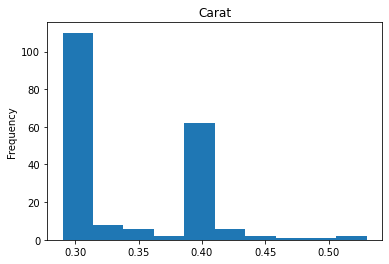

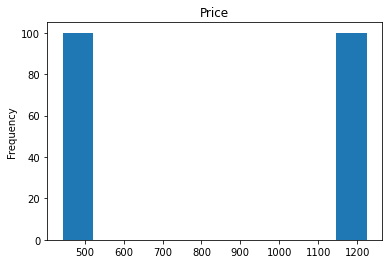

In [187]:
df_clean['carat'].plot.hist(bins=10)
plt.title('Carat')
plt.show()

df_clean['price'].plot.hist(bins=10)
plt.title('Price')
plt.show()

In [188]:
df_clean.loc[df_clean.price.gt(900)]

,id,sku,idprefix,name,shape,price,carat,cut,color,clarity,polish,symmetry,fluorescence,girdle,culet,media,v360,certificate,report_no,url
0,4054065627,4054065627,VD,0.40 Carat F-SI1 Excellent Ideal Diamond,Round,1218,0.40,Ideal,F,SI1,EX,EX,Med or Better,Medium to Slightly Thick,NONE,https://photo.diamondasset.in:8080/imagesM/241...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/241...,2417307781,https://www.michaeltrio.com/loose-diamonds/rou...
1,2025908686,2025908686,VD,0.40 Carat F-SI2 Excellent Ideal Diamond,Round,1218,0.40,Ideal,F,SI2,EX,EX,Non,Slightly Thick,NONE,https://photo.diamondasset.in:8080/imagesM/741...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/741...,7411307489,https://www.michaeltrio.com/loose-diamonds/rou...
2,4159181602,4159181602,VD,0.41 Carat J-VS1 Excellent Ideal Diamond,Round,1218,0.41,Ideal,J,VS1,EX,EX,Fnt,Medium to Slightly Thick,NONE,https://photo.diamondasset.in:8080/imagesM/641...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/641...,6412146253,https://www.michaeltrio.com/loose-diamonds/rou...
3,9217019770,9217019770,VD,0.31 Carat F-VVS1 Excellent Ideal Diamond,Round,1218,0.31,Ideal,F,VVS1,EX,EX,Fnt,Medium to Slightly Thick,NONE,https://d213t4exkgxsjh.cloudfront.net/assets/i...,,https://photo.diamondasset.in:8080/Picture/141...,1413070663,https://www.michaeltrio.com/loose-diamonds/rou...
4,3672092803,3672092803,VD,0.40 Carat F-SI2 Excellent Ideal Diamond,Round,1218,0.40,Ideal,F,SI2,EX,EX,Non,Slightly Thick,NONE,https://photo.diamondasset.in:8080/imagesM/741...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/741...,7413227679,https://www.michaeltrio.com/loose-diamonds/rou...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3773192636,3773192636,HVD,0.40 Carat I-VS2 Excellent Very Good Diamond,Round,1224,0.40,Very Good,I,VS2,EX,VG,Non,Medium to Thick,NONE,https://diamanti.s3.amazonaws.com/images/diamo...,https://diamanti.s3.amazonaws.com/video/Vision...,https://diamanti.s3.amazonaws.com/certificates...,1435558390,https://www.michaeltrio.com/loose-diamonds/rou...
96,3340128710,3340128710,VD,0.33 Carat D-VVS1 Very Good Ideal Diamond,Round,1224,0.33,Ideal,D,VVS1,VG,EX,Non,Medium to Slightly Thick,NONE,https://photo.diamondasset.in:8080/imagesM/239...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/239...,2397398819,https://www.michaeltrio.com/loose-diamonds/rou...
97,5123501050,5123501050,VD,0.40 Carat G-SI1 Excellent Ideal Diamond,Round,1225,0.40,Ideal,G,SI1,EX,VG,Non,Thin to Slightly Thick,NONE,https://photo.diamondasset.in:8080/imagesM/640...,https://photo.diamondasset.in/photo/appVideo.j...,https://photo.diamondasset.in:8080/Picture/640...,6402449380,https://www.michaeltrio.com/loose-diamonds/rou...
98,4137869209,4137869209,HVD,0.30 Carat F-IF Excellent Ideal Diamond,Round,1225,0.30,Ideal,F,IF,EX,EX,Non,Slightly Thick,NONE,https://diamanti.s3.amazonaws.com/images/diamo...,https://diamanti.s3.amazonaws.com/video/Vision...,https://diamanti.s3.amazonaws.com/certificates...,3435596457,https://www.michaeltrio.com/loose-diamonds/rou...


In [178]:
X = pd.get_dummies(
  df_clean[['carat', 'cut', 'color', 'clarity', 'polish', 'symmetry', 'fluorescence', 'culet']],
  columns=['cut', 'color', 'clarity', 'polish', 'symmetry', 'fluorescence', 'culet']
)
y = df_clean.price

In [179]:
import statsmodels.api as sm

In [180]:
model = sm.OLS(y, X)

In [181]:
fitted = model.fit()

In [182]:
fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     798.8
Date:                Mon, 27 Jun 2022   Prob (F-statistic):          1.66e-165
Time:                        09:41:51   Log-Likelihood:                -998.78
No. Observations:                 200   AIC:                             2048.
Df Residuals:                     175   BIC:                             2130.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
carat                       3689.0735     82.938     44.480      0.000    3525.386    3852.761
cut_Good                     -86.0251     19.263     -4.466      0.000    -124.042     -48.008
cut_Ideal                    -14.8125     11.488     -1.289      0.199     -37.486       7.860
cut_Pure Hearts               22.7671     23.846      0.955      0.341     -24.296      69.831
cut_Very Good                -31.5017     12.012     -2.623      0.009     -55.209      -7.795
color_D                      103.3714     12.983      7.962      0.000      77.749     128.994
color_E                      103.0205     11.004      9.362      0.000      81.303     124.738
color_F                      105.6995      9.239     11.440      0.000      87.465     123.934
color_G                       73.5291      9.688      7.590      0.000      54.409      92.649
color_H                       38.2158     13.204      2.894      0.004      12.157      64.275
color_I                       14.5342     11.387      1.276      0.204      -7.939      37.008
color_J                     -233.9387      8.227    -28.437      0.000    -250.175    -217.703
color_K                     -314.0040      7.402    -42.422      0.000    -328.612    -299.395
clarity_IF                   130.9137     21.395      6.119      0.000      88.689     173.139
clarity_SI1                 -141.1612      9.439    -14.955      0.000    -159.790    -122.532
clarity_SI2                 -224.6269      8.144    -27.580      0.000    -240.701    -208.553
clarity_VS1                    1.1779     16.787      0.070      0.944     -31.953      34.309
clarity_VS2                  -91.5201     12.507     -7.317      0.000    -116.204     -66.836
clarity_VVS1                 123.4363     11.018     11.203      0.000     101.691     145.182
clarity_VVS2                  92.2081     16.939      5.443      0.000      58.777     125.639
polish_EX                    -35.9552     14.792     -2.431      0.016     -65.149      -6.761
polish_GD                    -17.4888     33.988     -0.515      0.608     -84.568      49.590
polish_VG                    -56.1282     15.707     -3.573      0.000     -87.128     -25.128
symmetry_EX                   -6.6615      9.321     -0.715      0.476     -25.057      11.734
symmetry_GD                  -75.2884     13.605     -5.534      0.000    -102.139     -48.438
symmetry_VG                  -27.6223      9.013     -3.065      0.003     -45.410      -9.835
fluorescence_Fnt             -31.0523      7.889     -3.936      0.000     -46.621     -15.483
fluorescence_Med or Better   -60.3669     11.829     -5.103      0.000     -83.713     -37.021
fluorescence_Non             -18.1531      7.381     -2.460      0.015     -32.719      -3.587
culet_NONE                   -74.1333     1